# Renda dos Estadunidenses:

age: continuous.

workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.

fnlwgt: continuous.

education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

education-num: continuous.

marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

sex: Female, Male.

capital-gain: continuous.

capital-loss: continuous.

hours-per-week: continuous.

native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, 
Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from ml_libs import resample
from ml_libs import metrics
from ml_libs import transform
from importlib import reload
import matplotlib.pyplot as plt

In [2]:
reload(resample)
reload(metrics)
reload(transform)

<module 'ml_libs.transform' from '/home/lucas/Documentos/Semestre 7/Aprendizado-de-Maquina/Meus/Lista 6  - Renda dos Estadunidenses/ml_libs/transform.py'>

# Lendo os Dados

In [3]:
cols = ['Age', 'Workclass', 'FNWGT', 'Education', 'Education-num', 'Marital-Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-Gain', 'Capital-loss', 'Hours-Per-Week', 'Native-Country', 'Rich?']
dataset = pd.read_csv('adult.data', names = cols, sep=',\s+', engine='python', na_values = '?')

# Analisando os dados 

In [4]:
dataset.head()

,Age,Workclass,FNWGT,Education,Education-num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-loss,Hours-Per-Week,Native-Country,Rich?
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null int64
Workclass         30725 non-null object
FNWGT             32561 non-null int64
Education         32561 non-null object
Education-num     32561 non-null int64
Marital-Status    32561 non-null object
Occupation        30718 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null object
Capital-Gain      32561 non-null int64
Capital-loss      32561 non-null int64
Hours-Per-Week    32561 non-null int64
Native-Country    31978 non-null object
Rich?             32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
dataset.isna().sum()

Age                  0
Workclass         1836
FNWGT                0
Education            0
Education-num        0
Marital-Status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital-Gain         0
Capital-loss         0
Hours-Per-Week       0
Native-Country     583
Rich?                0
dtype: int64

# Preprocessamento

### Analisando dados faltantes ou desnecessários

###### Deteletando a colunda Education, ja que a coluna education-num possui as informações enumeradas

In [7]:
dataset.drop(labels=['Education'], axis=1, inplace=True)
dataset.head()

,Age,Workclass,FNWGT,Education-num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-loss,Hours-Per-Week,Native-Country,Rich?
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


###### Adicionando os valores faltantes a partir das médias dos outros dados

In [8]:
for column in ['Workclass', 'Occupation', 'Native-Country']:
    dataset[column] = dataset[column].replace(np.nan, dataset[column].mode()[0])

###### Tornando todos os valores categóricos binários

In [9]:
categorical_columns = dataset.select_dtypes(['object']).columns
dataset = pd.get_dummies(dataset, columns=categorical_columns ,prefix=categorical_columns, drop_first=True)
dataset = dataset.rename(columns={'Rich?_>50K':'Rich?'})

###### Analisando dados após todos os procedimentos

In [10]:
dataset.isnull().sum()

Age                                          0
FNWGT                                        0
Education-num                                0
Capital-Gain                                 0
Capital-loss                                 0
Hours-Per-Week                               0
Workclass_Local-gov                          0
Workclass_Never-worked                       0
Workclass_Private                            0
Workclass_Self-emp-inc                       0
Workclass_Self-emp-not-inc                   0
Workclass_State-gov                          0
Workclass_Without-pay                        0
Marital-Status_Married-AF-spouse             0
Marital-Status_Married-civ-spouse            0
Marital-Status_Married-spouse-absent         0
Marital-Status_Never-married                 0
Marital-Status_Separated                     0
Marital-Status_Widowed                       0
Occupation_Armed-Forces                      0
Occupation_Craft-repair                      0
Occupation_Ex

In [11]:
dataset.head()


,Age,FNWGT,Education-num,Capital-Gain,Capital-loss,Hours-Per-Week,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,Workclass_Self-emp-inc,...,Native-Country_Puerto-Rico,Native-Country_Scotland,Native-Country_South,Native-Country_Taiwan,Native-Country_Thailand,Native-Country_Trinadad&Tobago,Native-Country_United-States,Native-Country_Vietnam,Native-Country_Yugoslavia,Rich?
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Separação dos dados

In [12]:
X = dataset.values[:, :-1]
y = dataset.values[:,  -1]
y

array([0, 0, 0, ..., 0, 0, 1])

In [13]:
perc_train = 0.7
seed = 1
Xid_train, Xid_test = resample.split_stratified_train_test(y, perc_train, seed)

In [14]:
X_train = X[Xid_train]
X_test = X[Xid_test]
y_train = y[Xid_train]
y_test = y[Xid_test]

# Modelos

### Modelo normal

In [15]:
models = {}
models['SGDClassifier'] = {'model': SGDClassifier(tol=0.01, max_iter=300), 'predict': [], 'acc':0}
models['SVM'] = {'model': SVC(gamma='scale'), 'predict': [], 'acc':0}
models['KNeighborsClassifier'] = {'model': KNeighborsClassifier(), 'predict': [], 'acc':0}

In [16]:
for key in models:
    models[key]['model'].fit(X_train, y_train)
    models[key]['predict'] = models[key]['model'].predict(X_test)
    models[key]['acc'] = metrics.accuracy(y_test, models[key]['predict'])    

In [17]:
acc_n = []
for key in models: #achar ua forma melhor
    acc_n.append(models[key]['acc'])

(0.75, 0.79)

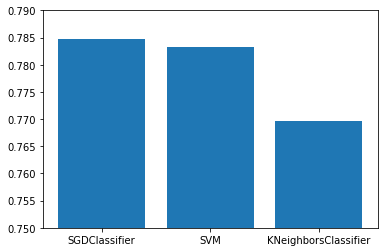

In [18]:
plt.bar(models.keys(), acc_n)
plt.ylim(0.75, 0.79)

### Modelo normalizado

In [19]:
models_norm = {}
models_norm['SGDClassifier'] = {'model': SGDClassifier(tol=0.001, max_iter=300), 'predict': [], 'acc':0}
models_norm['SVM'] = {'model': SVC(gamma='scale'), 'predict': [], 'acc':0}
models_norm['KNeighborsClassifier'] = {'model': KNeighborsClassifier(), 'predict': [], 'acc':0}

###### Normalizando os dados

In [20]:
transformation = transform.Normalize()
transformation.fit(X_train)
X_test_normalized = transformation.transform(X_test)
X_train_normalized = transformation.transform(X_train)

In [21]:
for key in models:
    models_norm[key]['model'].fit(X_train_normalized, y_train)
    models_norm[key]['predict'] = models_norm[key]['model'].predict(X_test_normalized)
    models_norm[key]['acc'] = metrics.accuracy(y_test, models_norm[key]['predict']) 

In [22]:
acc_nn = []
for key in models: #achar ua forma melhor
    acc_nn.append(models_norm[key]['acc'])

(0.7, 0.79)

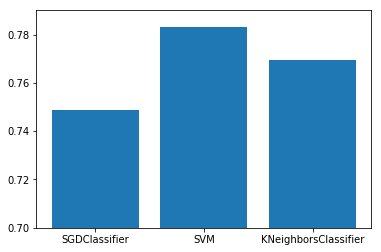

In [23]:
plt.bar(models_norm.keys(), acc_nn)
plt.ylim(0.70, 0.79)

### Modelo standartizado

In [24]:
models_stand = {}
models_stand['SGDClassifier'] = {'model': SGDClassifier(tol=0.001, max_iter=300), 'predict': [], 'acc':0}
models_stand['SVM'] = {'model': SVC(gamma='scale'), 'predict': [], 'acc':0}
models_stand['KNeighborsClassifier'] = {'model': KNeighborsClassifier(), 'predict': [], 'acc':0}

#### Estandartizando os dados

In [25]:
transformation = transform.Standardize()
transformation.fit(X_train)
X_test_estandartized = transformation.transform(X_test)
X_train_estandartized = transformation.transform(X_train)

In [26]:
for key in models:
    models_stand[key]['model'].fit(X_train_estandartized, y_train)
    models_stand[key]['predict'] = models_stand[key]['model'].predict(X_test_estandartized)
    models_stand[key]['acc'] = metrics.accuracy(y_test, models_stand[key]['predict']) 

In [27]:
acc_s = []
for key in models: #achar ua forma melhor
    acc_s.append(models_stand[key]['acc'])

(0.76, 0.79)

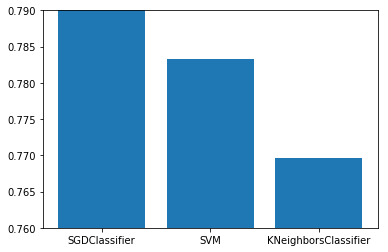

In [28]:
plt.bar(models_stand.keys(), acc_s)
plt.ylim(0.76, 0.79)

# Comparando todos os resultados

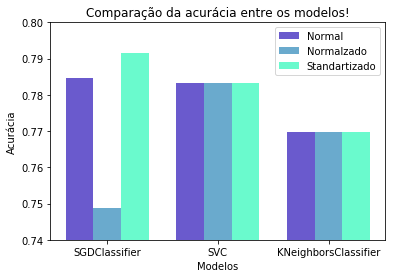

In [42]:
r1 = np.arange(len(acc_n))
r2 = [x+0.25 for x in r1]
r3 = [x+0.25 for x in r2]

plt.bar(r1, acc_n, color='#6A5ACD', width=0.25, label='Normal')
plt.bar(r2, acc_nn, color='#6AAACD', width=0.25, label='Normalzado')
plt.bar(r3, acc_s, color='#6AFACD', width=0.25, label='Standartizado')
plt.ylim(0.74, 0.80)
plt.xlabel('Modelos')
plt.xticks([r + 0.25 for r in range(len(acc_n))], ['SGDClassifier', 'SVC', 'KNeighborsClassifier'])
plt.ylabel('Acurácia')
plt.title('Comparação da acurácia entre os modelos!')
plt.legend()
plt.show()